<a href="https://colab.research.google.com/github/ngcaonghi/compneuro-explore/blob/master/steinmetz_dataset/GPFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import matplotlib and set defaults { form-width: "25%" }
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

!pip install plotly --quiet
import plotly.graph_objects as go

%config InlineBackend.figure_format = 'retina'

In [ ]:
#@title Import packages { form-width: "25%" }

!pip install neo elephant --quiet
import collections
import numpy as np
import os, requests
import neo
import quantities as pq
from elephant.gpfa import GPFA
import ipywidgets as widgets
from sklearn.model_selection import cross_val_score

In [ ]:
#@title Main data retrieval { form-width: "25%" }

# Code in this cell by Nick Steinmetz and Neuromatch Academy team.
# Link: https://github.com/NeuromatchAcademy/course-content/blob/master/projects/load_steinmetz_decisions.ipynb

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
#@title Main data loading { form-width: "25%" }
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

dat = alldat[11]

In [ ]:
#@title Data overview { form-width: "25%" }
@widgets.interact(key=widgets.Dropdown(options=list(dat.keys()), description="Key"))
def overview_field(key):
  d = dat[key]
  if isinstance(d, np.ndarray):
    print(d.shape)
    print("head sample:", d[:1])
    try:
      print("max:", np.max(d))
      print("min:", np.min(d))
      print("mean:", np.mean(d))
      print("median:", np.median(d))
      print("std", np.std(d))
      np.seterr(divide='ignore', invalid='ignore')
    except TypeError:
      pass
  elif isinstance(d, list):
      print(len(d))
      print("head sample:", d[:1])
  else:
      print(d)


interactive(children=(Dropdown(description='Key', options=('spks', 'wheel', 'pupil', 'response', 'response_tim…

In [ ]:
popul_by_area = collections.OrderedDict()
for i, area in enumerate(dat['brain_area']):
  if area not in popul_by_area:
    popul_by_area[area] = []
  popul_by_area[area].append(i)

for area in popul_by_area:
  print(area, len(popul_by_area[area]))

VISp 66
DG 65
SUB 105
LGd 11
PL 56
root 100
MOs 6
ACA 16
CA1 50
VISam 79
MD 126
LH 18


In [ ]:
def spike_generator(data=dat['spks']):
  neurons, trials, bins = data.shape
  trial_list = []
  for t in range(trials):
    trial = []
    for n in range(neurons):
      times = np.argwhere(data[n, t, :] > 0) * dat['bin_size'] * 1000
      times = times.astype(int)
      spike_train = neo.SpikeTrain(times=times, units=pq.ms, t_stop=2500)
      trial.append(spike_train)
    trial_list.append(trial)
  
  return trial_list



In [ ]:
neurons, trials, bins = dat['spks'].shape
np.random.seed(42)
TRAIN_SIZE = 300
train_idx = np.random.choice(np.arange(trials), 300, replace=False)
mask_test = np.ones(trials, dtype=bool)
mask_test[train_idx] = ~mask_test[train_idx]
test_idx = np.arange(trials)[mask_test]

In [ ]:
x_train = spike_generator(dat['spks'][:, train_idx, :])
x_test = spike_generator(dat['spks'][:, test_idx, :])
y_train = dat['wheel'][:, train_idx, :]
y_train = dat['wheel'][:, test_idx, :]

In [ ]:
bin_size = int(dat['bin_size'] * 1000) * pq.ms
latent_D = 3
gpfa_3dim = GPFA(bin_size=bin_size, x_dim = latent_D)

In [ ]:
gpfa_3dim.fit(x_train)

Initializing parameters using factor analysis...

Fitting GPFA model...


GPFA(bin_size=array(10.) * ms, em_max_iters=500, em_tol=1e-08, eps_init=0.001,
     freq_ll=5, min_var_frac=0.01, tau_init=array(100.) * ms, verbose=False,
     x_dim=3)

In [ ]:
traject = gpfa_3dim.transform(x_test)

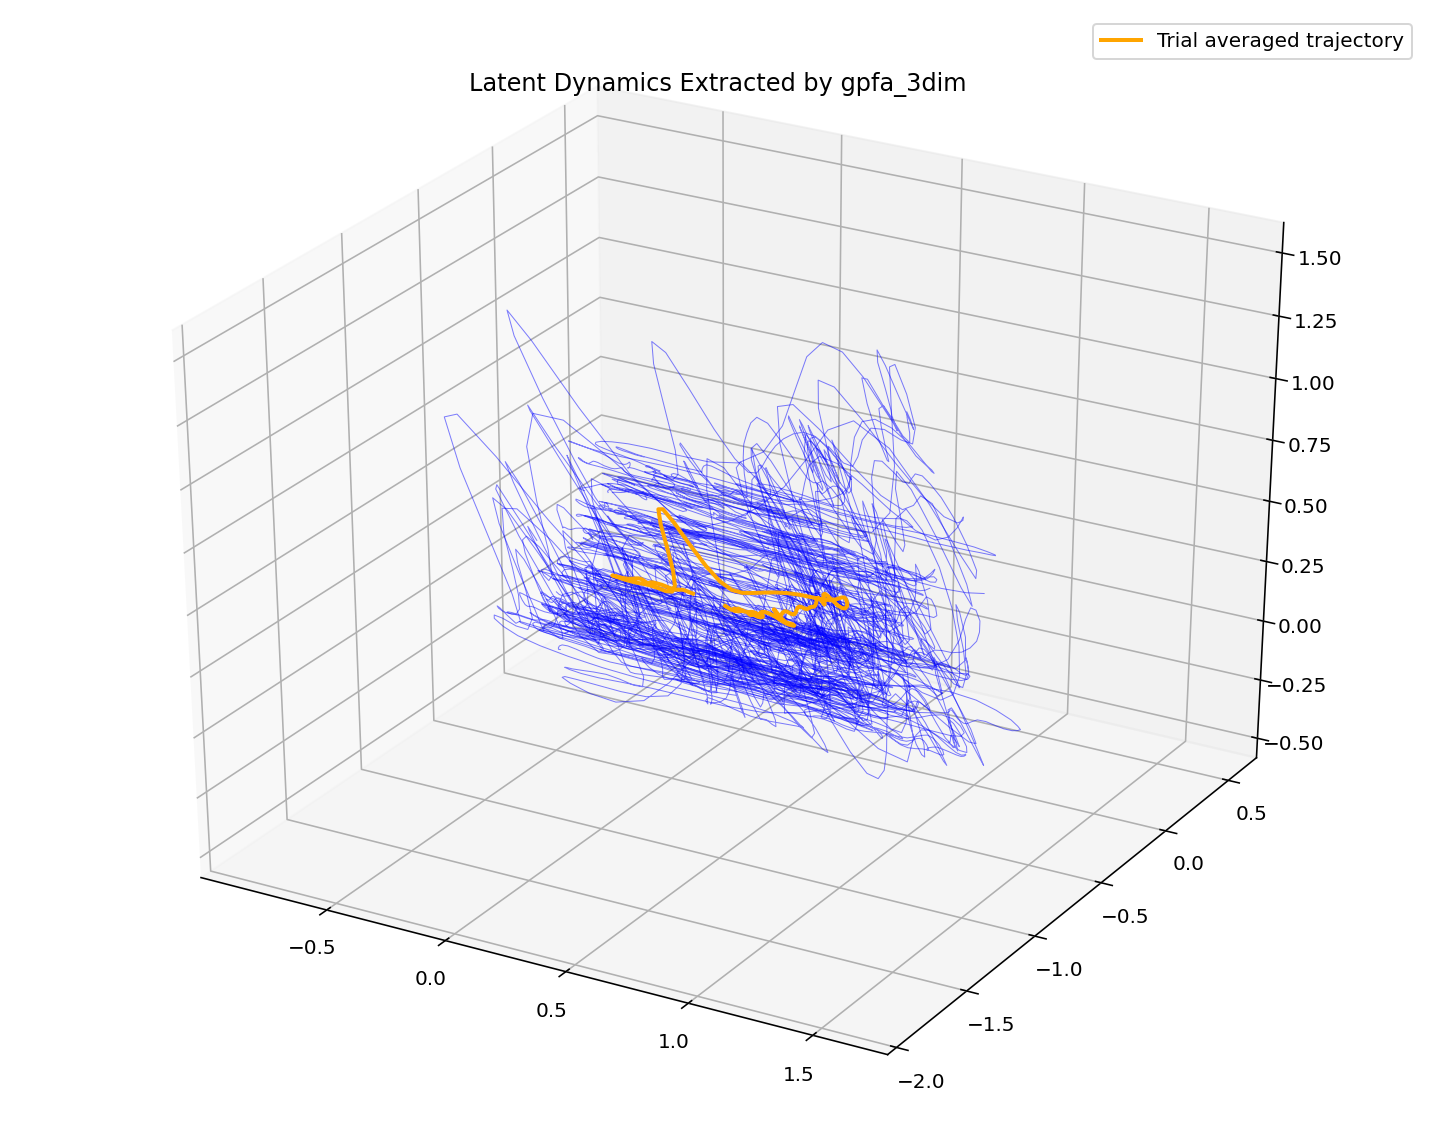

In [ ]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 2, projection='3d')
for t in traject:
  ax.plot(t[0], t[1], t[2], '-', linewidth=0.5, color='b', alpha=0.5)

average_t = np.mean(traject, axis=0)
ax.plot(average_t[0], average_t[1], average_t[2], '-', linewidth=2, color='orange', 
        label='Trial averaged trajectory')
ax.legend()
ax.set_title('Latent Dynamics Extracted by gpfa_3dim')
plt.show()

In [ ]:
x_dims = [2, 4, 16, 128]
log_likelihoods = []
for x_dim in x_dims:
    gpfa_cv = GPFA(x_dim=x_dim)
    cv_log_likelihoods = cross_val_score(gpfa_cv, x_train + x_test, 
                                         cv=3, n_jobs=-1, verbose=True)
    log_likelihoods.append(np.mean(cv_log_likelihoods))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 26.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
f = plt.figure(figsize=(7, 5))
plt.xlabel('Dimensionality of latent variables')
plt.ylabel('Log-likelihood')
plt.plot(x_dims, log_likelihoods, '.-')
plt.plot(x_dims[np.argmax(log_likelihoods)], np.max(log_likelihoods), 'x', markersize=10, color='r')
plt.show()

In [ ]:
from google.colab import drive
drive.mount(r'/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
import pickle
f = open('/content/gdrive/My Drive/compneuro/gpfa_3dim.pkl', 'wb')
pickle.dump(gpfa_3dim, f)
f.close()